In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp '/content/drive/MyDrive/DS/TFkeras/mango.zip' /content

In [4]:
!unzip /content/mango.zip -d /content/

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/mango/Train/00874.jpg  
  inflating: /content/mango/Train/00875.jpg  
  inflating: /content/mango/Train/00876.jpg  
  inflating: /content/mango/Train/00877.jpg  
  inflating: /content/mango/Train/00878.jpg  
  inflating: /content/mango/Train/00879.jpg  
  inflating: /content/mango/Train/00880.jpg  
  inflating: /content/mango/Train/00881.jpg  
  inflating: /content/mango/Train/00883.jpg  
  inflating: /content/mango/Train/00885.jpg  
  inflating: /content/mango/Train/00886.jpg  
  inflating: /content/mango/Train/00887.jpg  
  inflating: /content/mango/Train/00888.jpg  
  inflating: /content/mango/Train/00889.jpg  
  inflating: /content/mango/Train/00892.jpg  
  inflating: /content/mango/Train/00893.jpg  
  inflating: /content/mango/Train/00894.jpg  
  inflating: /content/mango/Train/00895.jpg  
  inflating: /content/mango/Train/00896.jpg  
  inflating: /content/mango/Train/00897.jpg  
  inflating: /content/mango/Train/00898.jpg  
  inflating: 

In [6]:
generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2,
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
    )

In [7]:
testgenerator = ImageDataGenerator(rescale = 1./255,
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
    )

In [8]:
target_size = [224, 224]
batch_size = 64

### mango 分A B C 等級
載入mango數據集 從 csv檔

In [9]:
train_dir = '/content/mango/Train/'
test_dir = '/content/mango/Dev/'
dftrain = pd.read_csv(r'/content/mango/train.csv')
dftest = pd.read_csv(r'/content/mango/dev.csv')
print(dftrain.shape, dftest.shape)
print(dftrain.head())

(5600, 2) (800, 2)
    image_id label
0  00002.jpg     C
1  00003.jpg     C
2  00004.jpg     B
3  00005.jpg     A
4  00007.jpg     A


In [10]:
train_gen = generator.flow_from_dataframe(dataframe=dftrain, directory=train_dir, x_col="image_id", y_col="label",
                                          class_mode="categorical",
                                          target_size=target_size,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          seed=101,
                                          subset='training')

val_gen = generator.flow_from_dataframe(dataframe=dftrain, directory=train_dir, x_col="image_id", y_col="label",
                                         class_mode="categorical",
                                         target_size=target_size,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         seed=101,
                                         subset='validation')

test_gen = testgenerator.flow_from_dataframe(dataframe=dftest, directory=test_dir, x_col="image_id", y_col="label",
                                         class_mode="categorical",
                                         target_size=target_size,
                                         batch_size=1,
                                         shuffle=False,
                                         )

Found 4480 validated image filenames belonging to 3 classes.
Found 1120 validated image filenames belonging to 3 classes.
Found 800 validated image filenames belonging to 3 classes.


In [11]:
print(train_gen.samples, val_gen.samples, test_gen.samples)

4480 1120 800


In [12]:
print(train_gen.class_indices)

{'A': 0, 'B': 1, 'C': 2}


In [13]:
# initializing label list and feeding in classes/indices
labels = [None]*len(train_gen.class_indices)

for item, indice in train_gen.class_indices.items():
    labels[indice] = item

In [14]:
labels

['A', 'B', 'C']

### 訓練Model

In [32]:
# 創建模型(不包含全連接層)，最後一層卷積加上GlobalAveragePooling
base_model = tf.keras.applications.EfficientNetV2S(include_top=False,
                               weights='imagenet',
                               pooling='avg',
                               input_shape=target_size+[3]) # [128, 128, 3] # w,h,c
# 將剛創建的InceptionV3模型接上兩層全連接層，並且最後一層使用Softmax輸出
model_1 = tf.keras.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [33]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 batch_normalization_4 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_11 (Dense)            (None, 128)               163968    
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 3)                

In [34]:
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/TFkeras/efficientnet_v2s.h5',
                                             monitor='val_categorical_accuracy',
                                             save_best_only=True,
                                             mode='max')
# 設定停止訓練的條件(當Accuracy超過5迭代沒有上升的話訓練會終止)
model_esp = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5)

In [35]:
adam = optimizers.Adam(learning_rate=1e-3)
rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=2, verbose=1, min_delta=0.0001)

model_1.compile(optimizer=adam,
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

In [36]:
history = model_1.fit_generator(generator=train_gen,
                        steps_per_epoch = train_gen.samples//batch_size,
                        validation_data=val_gen,
                        validation_steps= val_gen.samples//batch_size,
                        epochs=30,
                        callbacks=[rlr, model_mckp, model_esp])

<ipython-input-36-b1951d1762b8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_1.fit_generator(generator=train_gen,


Epoch 1/30
70/70 [==============================] - 258s 2s/step - loss: 0.7645 - categorical_accuracy: 0.6705 - val_loss: 0.8478 - val_categorical_accuracy: 0.5248 - lr: 0.0010
Epoch 2/30
70/70 [==============================] - 156s 2s/step - loss: 0.5916 - categorical_accuracy: 0.7397 - val_loss: 0.7425 - val_categorical_accuracy: 0.6094 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - 130s 2s/step - loss: 0.5345 - categorical_accuracy: 0.7656 - val_loss: 0.7842 - val_categorical_accuracy: 0.5588 - lr: 0.0010
Epoch 4/30
70/70 [==============================] - 139s 2s/step - loss: 0.5933 - categorical_accuracy: 0.7500 - val_loss: 0.7205 - val_categorical_accuracy: 0.6489 - lr: 0.0010
Epoch 5/30
70/70 [==============================] - 156s 2s/step - loss: 0.5306 - categorical_accuracy: 0.7665 - val_loss: 0.6567 - val_categorical_accuracy: 0.6985 - lr: 0.0010
Epoch 6/30
70/70 [==============================] - 128s 2s/step - loss: 0.5606 - categorical_accuracy: 0.7618

In [38]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
import itertools

def get_conf_matrix(model, data_dir, size, image_size):
    predictions =[]
    true_y = []
    for x,y in test_gen: #testgenerator.flow_from_directory(data_dir, batch_size=1, target_size=image_size, shuffle=False):
        predprob = model.predict(x)
        # decoding one-hot
        prediction = np.argmax(predprob, axis=1)
        y = np.argmax(y, axis =1)

        predictions = np.concatenate((predictions, prediction))
        true_y = np.concatenate((true_y, y))
        if len(predictions) >=size:
            break
    matrix = confusion_matrix(true_y, predictions)

    return matrix

In [41]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TFkeras/efficientnet_v2s.h5')
conf_matrix_inc = get_conf_matrix(model, test_dir, test_gen.samples, target_size)
print(conf_matrix_inc[:,:])
del model
K.clear_session()

1/1 [==============================] - 0s 35ms/step
[[203  37   3]
 [ 46 227  20]
 [  2  33 229]]


Confusion matrix, without normalization
[[203  37   3]
 [ 46 227  20]
 [  2  33 229]]


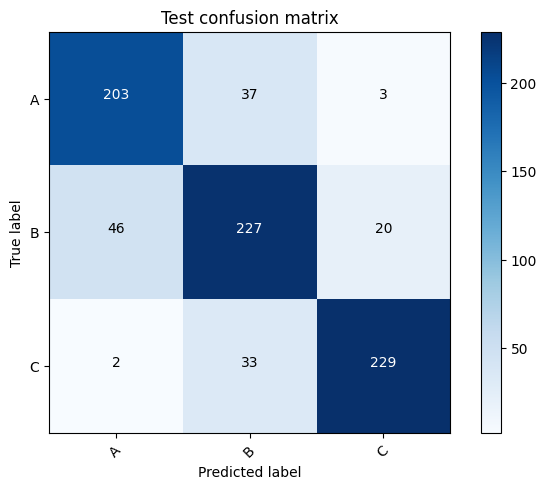

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=False`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(conf_matrix_inc, labels, title = "Test confusion matrix")

In [50]:
sum([conf_matrix_inc[i, i] for i in range(3)])/test_gen.samples

0.82375

In [51]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
import itertools

def get_conf_matrix(model, data_dir, lenlab, size, image_size):
    prediction = []
    predictions = []
    true_y = []
    predictprob = np.empty([size, lenlab])

    ix = 0
    for x,y in test_gen: # testgenerator.flow_from_directory(data_dir, batch_size=1, target_size=image_size, shuffle=False):
        prediction =  model.predict(x) # (1,2)
        predictprob[ix,:] = prediction
        # decoding one-hot
        prediction = np.argmax(prediction, axis=1)
        y = np.argmax(y, axis =1)

        predictions = np.concatenate((predictions, prediction))
        true_y = np.concatenate((true_y, y))
        if len(predictions) >=size:
            break
        ix+=1

    matrix = confusion_matrix(true_y, predictions)

    return predictprob, matrix

In [52]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TFkeras/EfficientNetV2S2.h5')
pred_v2s2, conf_matrix_v2s2 = get_conf_matrix(model, test_dir, len(labels), test_gen.samples, target_size)
#print(conf_matrix_resnet[:,:])
del model
K.clear_session()

1/1 [==============================] - 0s 39ms/step


In [53]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TFkeras/efficientnet_v2s.h5')
pred_v2s, conf_matrix_v2s = get_conf_matrix(model, test_dir, len(labels), test_gen.samples, target_size)
#print(conf_matrix_resnet[:,:])
del model
K.clear_session()

1/1 [==============================] - 0s 54ms/step


In [61]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [58]:
true_y = []
for _,y in test_gen: # testgenerator.flow_from_directory(test_dir, batch_size=1, target_size=target_size, shuffle=False):
    # decoding one-hot
    y = np.argmax(y, axis =1)
    true_y = np.concatenate((true_y, y))
    if len(true_y)>=test_gen.samples:
        break

Normalized confusion matrix
[[0.85185185 0.14403292 0.00411523]
 [0.15358362 0.778157   0.06825939]
 [0.00757576 0.14393939 0.84848485]]


0.82375

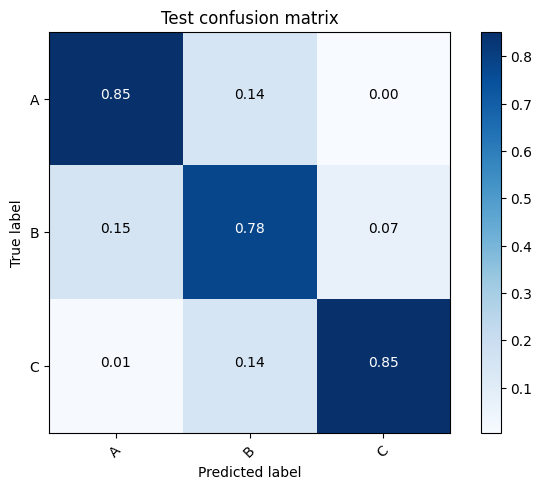

In [60]:
predmean = (pred_v2s2 + pred_v2s) / 2.
predictions = np.argmax(predmean, axis=1)
conf_matrix = confusion_matrix(true_y, predictions) # sklearn
plot_confusion_matrix(conf_matrix, labels, title = "Test confusion matrix")
sum([conf_matrix[i, i] for i in range(3)])/test_gen.samples